In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-20 13:58:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   201MB/s    in 0.3s    

2022-03-20 13:58:44 (201 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [4]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/') 

# ImageDataGenerator 이용하여 데이터 불러옴

In [5]:
train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

val_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

validation_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [7]:
IMG_WIDTH=224
IMG_HEIGHT=224

In [8]:
train_generator = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


validation_generator = val_data_gen.flow_from_directory(validation_dir, batch_size=32, 
                                              color_mode='rgb', shuffle=True, 
                                              class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# 정답 확인

print(train_generator.class_indices)
print(validation_generator.class_indices)

print(len(train_generator.classes))
print(len(validation_generator.classes))

print(train_generator.num_classes)
print(validation_generator.num_classes)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
2000
1000
2
2


# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [10]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [11]:
class_nums = train_generator.num_classes

model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
Non-

In [12]:
# 모델 컴파일

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [14]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/20
63/63 [==============================] - 53s 630ms/step - loss: 0.5080 - accuracy: 0.7405 - val_loss: 0.3391 - val_accuracy: 0.8580
Epoch 2/20
63/63 [==============================] - 39s 617ms/step - loss: 0.2338 - accuracy: 0.9225 - val_loss: 0.1896 - val_accuracy: 0.9340
Epoch 3/20
63/63 [==============================] - 38s 598ms/step - loss: 0.1539 - accuracy: 0.9510 - val_loss: 0.1146 - val_accuracy: 0.9670
Epoch 4/20
63/63 [==============================] - 37s 588ms/step - loss: 0.1131 - accuracy: 0.9610 - val_loss: 0.0856 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 38s 601ms/step - loss: 0.0812 - accuracy: 0.9730 - val_loss: 0.0643 - val_accuracy: 0.9830
Epoch 6/20
63/63 [==============================] - 37s 588ms/step - loss: 0.0724 - accuracy: 0.9740 - val_loss: 0.0528 - val_accuracy: 0.9850
Epoch 7/20
63/63 [==============================] - 37s 585ms/step - loss: 0.0575 - accuracy: 0.9835 - val_loss: 0.0407 - val_accuracy: 0.9870

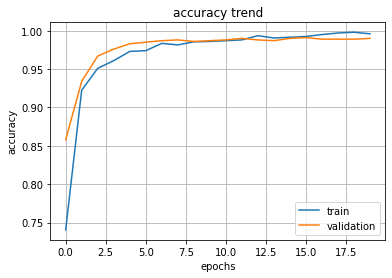

In [15]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

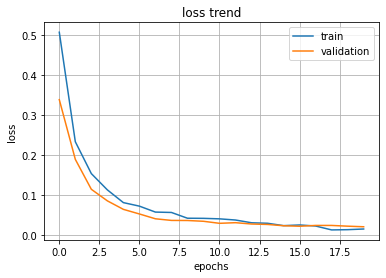

In [16]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

# 테스트 이미지 확인

In [17]:
import zipfile

with zipfile.ZipFile('/content/test_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_dir/')

In [18]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('/content/test_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/test_dir/test3.jpg', '/content/test_dir/test1.jpg', '/content/test_dir/test4.jpg', '/content/test_dir/test2.png', '/content/test_dir/test6.png', '/content/test_dir/test5.jpg']
6


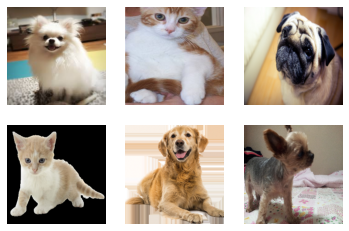

In [19]:
plt.figure(figsize=(6,4))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [20]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [21]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [22]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[4.6371892e-01 5.3628111e-01]
 [9.9986839e-01 1.3159726e-04]
 [2.0939255e-02 9.7906071e-01]
 [9.9944025e-01 5.5977097e-04]
 [1.6299621e-04 9.9983692e-01]
 [7.6545745e-02 9.2345428e-01]]


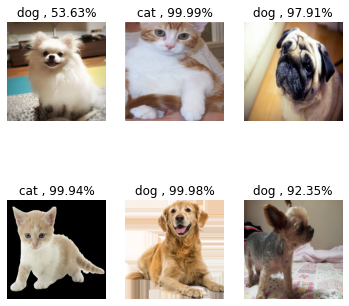

In [23]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(6,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()